# Project 1, Part 5, Best Customer Analytics

University of California, Berkeley
Master of Information and Data Science (MIDS) program
w205 - Fundamentals of Data Engineering

Student: Landon Morin

Year: 2022

Semester: Spring

Section: 9


# Included Modules and Packages

Code cell containing your includes for modules and packages

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mticker
from calendar import day_name
import warnings


import psycopg2

# Supporting code

Code cells containing any supporting code, such as connecting to the database, any functions, etc.  Remember you can use any code from the labs.

In [2]:
# pandas puts all numeric values from postgres to float
# if it will fit in an integer, change it to integer
#

def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    "function to run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # fix the float columns that really should be integers
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)

In [3]:
connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)

In [4]:
cursor = connection.cursor()
warnings.filterwarnings('ignore')

## The executives want you to come up with a high level design of a model, in the form of written criteria, to determine who the best customers are. 

## You do NOT have to code the model. 

## You do NOT have to give an actual list of best customers. 

## Create an executive summary explaining your model. You must support your summary with data, in the form of output of queries, data visualization, etc. There is a 1 query minimum.

# Queries
**Note: Queries may take some time to process**

In [5]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select c.customer_id as customer, 
       c.distance as distance_from_store, 
       s.city as store,
       count(distinct(sa.sale_id, sa.store_id)) as total_visits, 
       sum(l.quantity) as total_meals,
       sum(sa.total_amount) as total_sales
from stores as s
    left join customers as c
        on c.closest_store_id = s.store_id
    left join sales as sa
        on c.customer_id = sa.customer_id
    left join line_items as l
        on l.sale_id = sa.sale_id
group by c.customer_id, s.city
order by total_sales

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,customer,distance_from_store,store,total_visits,total_meals,total_sales
0,1528,3,Berkeley,16,273,7536
1,105,1,Berkeley,17,234,7932
2,6485,12,Berkeley,9,191,8256
3,12861,9,Seattle,14,278,9240
4,1757,3,Berkeley,17,340,9432
...,...,...,...,...,...,...
31077,7600,15,Berkeley,1,<NA>,<NA>
31078,2378,4,Berkeley,1,<NA>,<NA>
31079,10900,6,Seattle,1,<NA>,<NA>
31080,5366,9,Berkeley,1,<NA>,<NA>


In [6]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select c.customer_id as customer, 
       c.distance as distance_from_store, 
       s.city as store,
       count(distinct(sa.sale_id, sa.store_id)) as total_visits, 
       sum(sa.total_amount) as total_sales, 
       z.density as density, 
       z.population as population
from stores as s
    left join customers as c
        on c.closest_store_id = s.store_id
    left join zip_codes as z
        on c.zip = z.zip
    left join sales as sa
        on c.customer_id = sa.customer_id
group by c.customer_id, s.city, z.zip
order by total_sales

"""

df2 = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df2

,customer,distance_from_store,store,total_visits,total_sales,density,population
0,6485,12,Berkeley,9,612,23198.27,44239
1,22530,3,Miami,14,648,8756.24,33464
2,12861,9,Seattle,14,672,3358.96,21619
3,1528,3,Berkeley,16,684,13421.84,31496
4,15264,22,Seattle,12,708,3024.07,21012
...,...,...,...,...,...,...,...
31077,19556,9,Dallas,1,<NA>,1007.25,30682
31078,11113,6,Seattle,1,<NA>,8138.00,35111
31079,11471,7,Seattle,1,<NA>,2357.41,18765
31080,10999,6,Seattle,1,<NA>,8138.00,35111


In [7]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select c.customer_id as customer, 
       sa.sale_date as sale_date,
       c.distance as distance_from_store, 
       s.city as store,
       sum(sa.total_amount) as total_sales, 
       z.density, 
       z.population
from stores as s
    left join customers as c
        on c.closest_store_id = s.store_id
    left join zip_codes as z
        on c.zip = z.zip
    left join sales as sa
        on c.customer_id = sa.customer_id
group by sa.sale_date, c.customer_id, s.city, z.density, z.population
order by total_sales

"""

df3 = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df3

,customer,sale_date,distance_from_store,store,total_sales,density,population
0,16781,2020-09-29,4,Dallas,12,5078.71,29720
1,16668,2020-09-29,3,Dallas,12,4039.87,15128
2,16609,2020-09-29,3,Dallas,12,4039.87,15128
3,26740,2020-09-27,13,Miami,12,8146.81,45243
4,16548,2020-09-29,3,Dallas,12,4039.87,15128
...,...,...,...,...,...,...,...
1537647,7977,None,20,Berkeley,<NA>,1449.10,30048
1537648,28284,None,4,Nashville,<NA>,1626.00,14768
1537649,30333,None,11,Nashville,<NA>,1250.19,24229
1537650,23523,None,5,Miami,<NA>,7181.26,41861


# Exploratory Data Analysis

In [8]:
df = df.fillna(0)
df.store = pd.Categorical(df.store)


In [9]:
df['total_sales'] = df['total_sales'].astype(float)
df['total_visits'] = df['total_visits'].astype(float)
df2['total_sales'] = df2['total_sales'].astype(float)
df2['total_visits'] = df2['total_visits'].astype(float)

In [10]:
cities = df['store'].unique()
colors = sns.color_palette("flare")
x = list(df['total_visits'].values)
y = list(df['total_sales'].values)

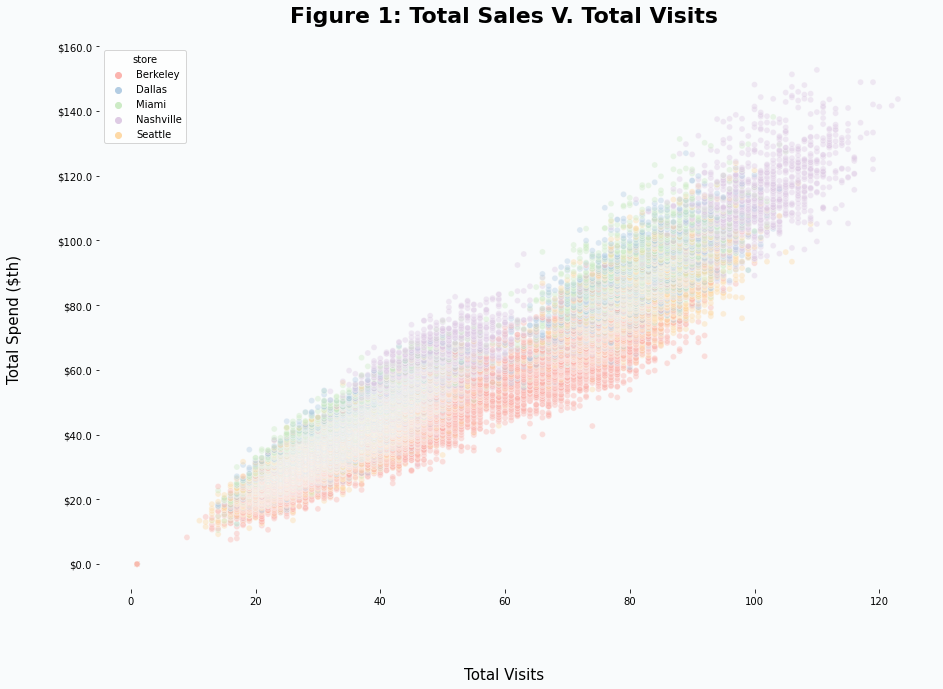

In [11]:
def thousands_formatter(x, pos):
    return f'${x / 1000}'
fig, ax = plt.subplots(figsize=(15, 10))

sns.scatterplot(data=df, x=x, 
                y=y, 
                hue = 'store',
                palette='Pastel1', 
                alpha = .4, ax=ax)

ax.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
ax.set_frame_on(False)


# Add titles (main and on axis)
fig.text(0.5, 0, 'Total Visits', ha='center', fontsize = 15)
fig.text(.04, .5, 'Total Spend ($th)', va='center', rotation='vertical', fontsize = 15)
fig.text(
    x=0.5, 
    y=0.92,
    s="Figure 1: Total Sales V. Total Visits",
    ha="center",
    va="center",
    ma="center",
    fontsize=22,
    fontweight="bold"
)

fig.set_facecolor("#f9fbfc")




**Figure 1 maps the relationship between total visits, and total spend per visit. We add store as a third dimension, and is signified by color. There is very close, positive correlation between total visits per customer and total spend per customer. In other words, more visits equals more revenue. There is not a significant amount of customers who visit infrequently, but buy in bulk.**

In [12]:
min_value = df['distance_from_store'].min()
max_value = df['distance_from_store'].max()

bins = np.linspace(min_value,max_value,5)

labels = ['1-6 Miles', '7-12 Miles', '13-18 Miles', '19-25 Miles']
df['bins'] = pd.cut(df['distance_from_store'], bins=bins, labels=labels, include_lowest=True)


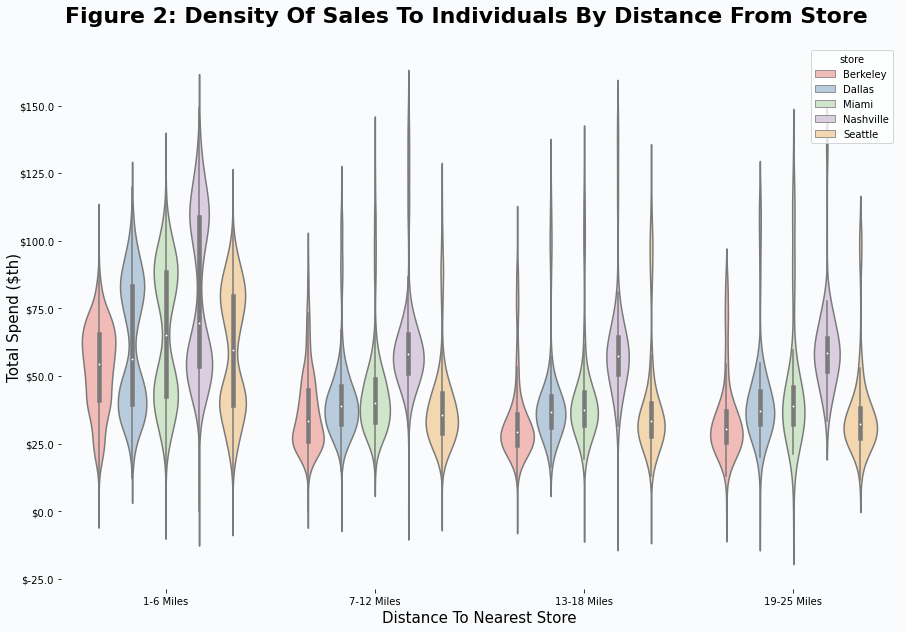

In [13]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.violinplot(x="bins", 
               y="total_sales", 
               hue="store", 
               data=df, 
               palette="Pastel1",
               ax=ax, 
               labels = False)

ax.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
ax.set_frame_on(False)


# Add titles (main and on axis)
plt.xlabel('Distance To Nearest Store', ha='center', fontsize = 15)
plt.ylabel('Total Spend ($th)', va='center', rotation='vertical', fontsize = 15)
fig.text(
    x=0.5, 
    y=0.92,
    s="Figure 2: Density Of Sales To Individuals By Distance From Store",
    ha="center",
    va="center",
    ma="center",
    fontsize=22,
    fontweight="bold"
)

fig.set_facecolor("#f9fbfc")





**Figure 2 provides insight into the density of spending by distance from store. For this visual, we have grouped distances into four categories of distance. These distance categories are further divided into store categories to provide a visualization of the relationship between spend and distance by store. There is clearly a higher density of large spending among customers who live close to their nearest store (between 1 and 6 miles). Beyond 6 miles of distance, the relationship between spending and distance from store appears to become weaker.** 

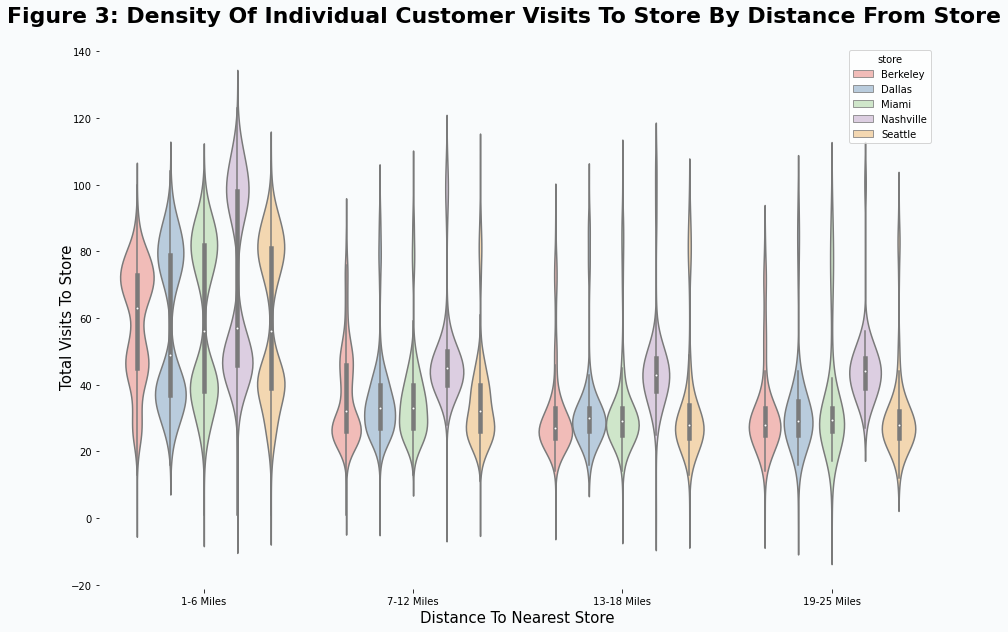

In [14]:
fig, ax = plt.subplots(figsize=(15, 10))


sns.violinplot(x="bins", y="total_visits", hue="store", data=df, palette="Pastel1")
ax.set_frame_on(False)


# Add titles (main and on axis)
plt.xlabel('Distance To Nearest Store', ha='center', fontsize = 15)
plt.ylabel('Total Visits To Store', va='center', rotation='vertical', fontsize = 15)
fig.text(
    x=0.5, 
    y=0.92,
    s="Figure 3: Density Of Individual Customer Visits To Store By Distance From Store",
    ha="center",
    va="center",
    ma="center",
    fontsize=22,
    fontweight="bold"
)

fig.set_facecolor("#f9fbfc")



plt.show()


**Figure 3 provides insight into the density of successful sales by distance from store. Like in Figure 2, we have grouped distances into four categories of distance, subdivided by store. There is clearly a higher density of total sales among customers who live close to their nearest store (between 1 and 6 miles). Beyond 6 miles of distance, the relationship between spending and distance from store appears to become weaker. This distribution supports the hypothesis that distance from the store is negatively correlated with number of visits.** 

In [15]:
min_value2 = df2['density'].min()
max_value2 = df2['density'].max()

bins2 = np.linspace(min_value2,max_value2,10)

labels2 = ['~<5.6k', '~5.6k-11k', '~11k-17k', '~17k-23k', '~23k-28k', '~28k-34k', '~34k-40k', '~40k-45k', '~45k-51k']
df2['bins'] = pd.cut(df2['density'], bins=bins2, labels=labels2, include_lowest=True)

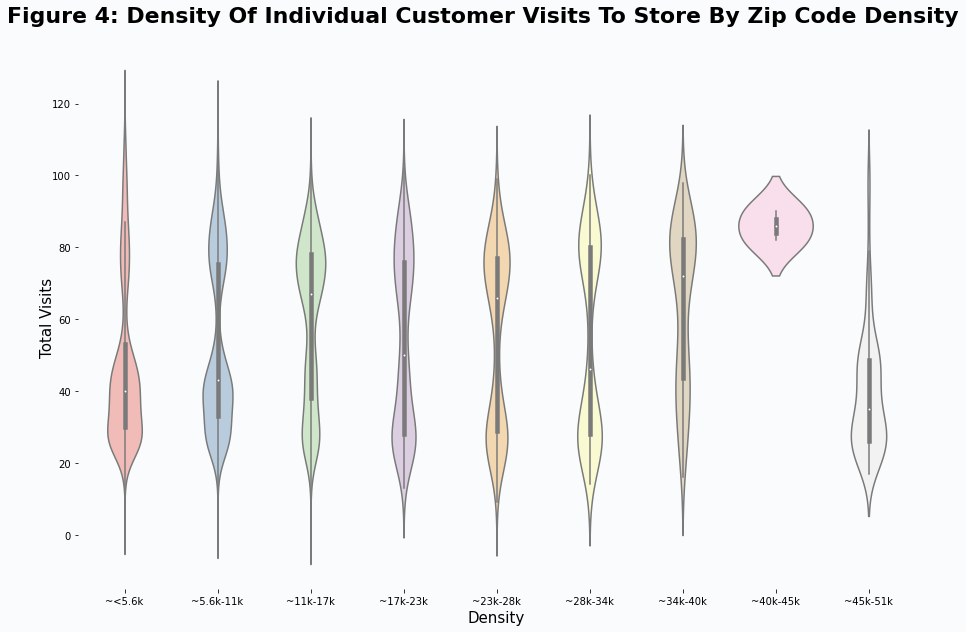

In [16]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.violinplot(x="bins", y="total_visits", data=df2, palette="Pastel1")
ax.set_frame_on(False)

plt.xlabel('Density', ha='center', fontsize = 15)
plt.ylabel('Total Visits', va='center', rotation='vertical', fontsize = 15)
fig.text(
    x=0.5, 
    y=0.92,
    s="Figure 4: Density Of Individual Customer Visits To Store By Zip Code Density",
    ha="center",
    va="center",
    ma="center",
    fontsize=22,
    fontweight="bold"
)

fig.set_facecolor("#f9fbfc")


**Figure 4 provides insight into the density of sales compared to the the density of the customer's zip code. For this visual, we have grouped densities into 9 categories. We hypothesize that higher densities will result in more sales as word of mouth spreads about our brand among many potential customers residing in a concentrated area. This visual does not support our hypothesis, though there seems to be more sales in the 34k-45k population density range. Otherwise the relationship between population density at the zip code level and sales is not obvious.** 

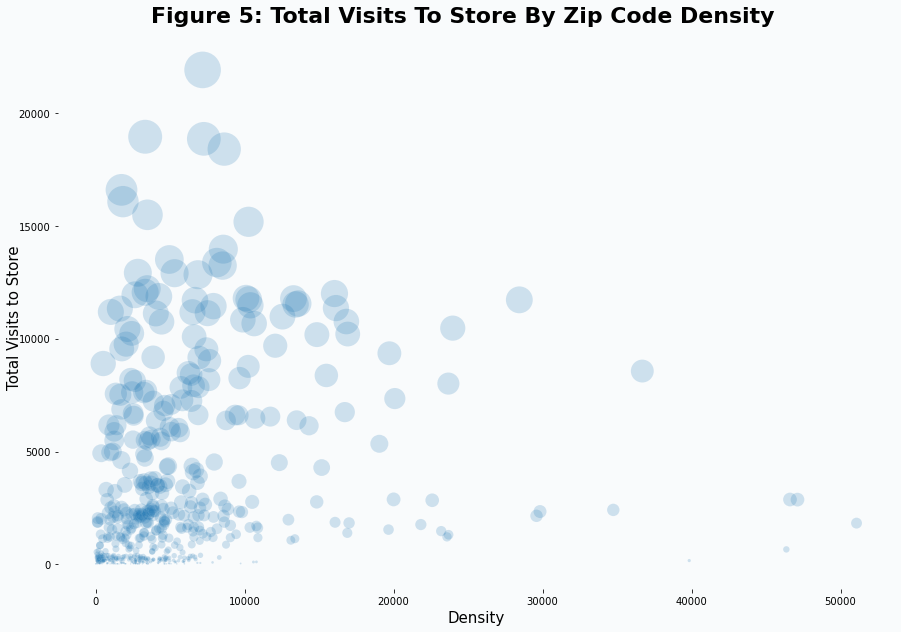

In [17]:
df_dense = df2.groupby('density').sum()
df_dense = df_dense.reset_index()

minsize = min(df_dense['total_sales'])/1000
maxsize = max(df_dense['total_sales'])/1000
fig, ax = plt.subplots(figsize=(15, 10))

sns.scatterplot(data=df_dense, x='density', 
                y='total_visits', 
                size='total_sales', 
                sizes=(minsize, maxsize), 
                alpha = .2, 
                ax=ax, legend = False)

ax.set_frame_on(False)

# Add titles (main and on axis)
ax.set_xlabel('Density', ha='center', fontsize = 15)
ax.set_ylabel('Total Visits to Store', va='center', rotation='vertical', fontsize = 15)
fig.text(
    x=0.5, 
    y=0.92,
    s="Figure 5: Total Visits To Store By Zip Code Density",
    ha="center",
    va="center",
    ma="center",
    fontsize=22,
    fontweight="bold"
)

fig.set_facecolor("#f9fbfc")



plt.show()




**Figure 5 shows an alternate view of the relationship between density and sales. There is a weakly positive relationship between density and sales up to a zip code density of around 11,000. Higher densities are weekly correlated with sales.** 

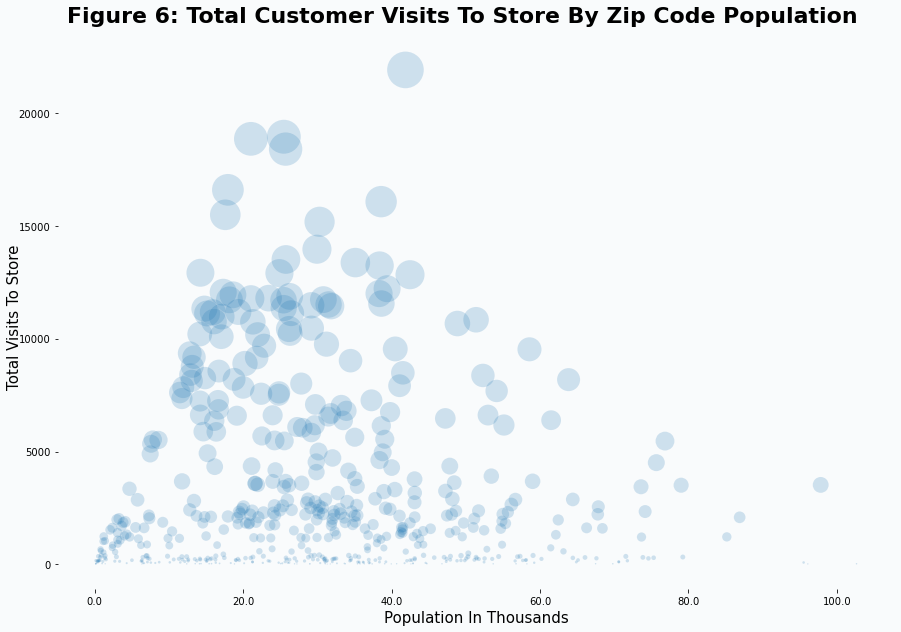

In [18]:
df_pop = df2.groupby('population').sum()
df_pop = df_pop.reset_index()

def thousand_formatter(x, pos):
    return f'{x / 1000}'

minsize = min(df_dense['total_sales'])/1000
maxsize = max(df_dense['total_sales'])/1000


fig, ax = plt.subplots(figsize=(15, 10))

sns.scatterplot(data=df_pop, x='population', 
                y='total_visits', size='total_sales', sizes=(minsize, maxsize), 
                alpha = .2, ax=ax, legend = False)

ax.set_frame_on(False)
ax.xaxis.set_major_formatter(FuncFormatter(thousand_formatter))


# Add titles (main and on axis)
ax.set_xlabel('Population In Thousands', ha='center', fontsize = 15)
ax.set_ylabel('Total Visits To Store', va='center', rotation='vertical', fontsize = 15)
fig.text(
    x=0.5, 
    y=0.92,
    s="Figure 6: Total Customer Visits To Store By Zip Code Population",
    ha="center",
    va="center",
    ma="center",
    fontsize=22,
    fontweight="bold"
)

fig.set_facecolor("#f9fbfc")


plt.show()





**Figure 6 shows the relationship between zip code population and total sales from that zip code. There is a weak positive correlation between number of sales to customers residing in a zip code and the population of that zip code. There are more customers in largely populated areas, and there may be network effects which result in more total sales. Additionally, population is correlated with total revenue as well, which is shown by the size of the plot markers.** 

In [19]:
min_value = df3['distance_from_store'].min()
max_value = df3['distance_from_store'].max()

bins = np.linspace(min_value,max_value,5)

labels = ['1-6 Miles', '7-12 Miles', '13-18 Miles', '19-25 Miles']
df3['bins'] = pd.cut(df3['distance_from_store'], bins=bins, labels=labels, include_lowest=True)

df3_dense = df3.groupby(['bins', 'sale_date']).sum().reset_index()
df3_dense

df3_dense.drop(['distance_from_store', 'density', 'population'], axis = 1, inplace=True)


In [20]:
df3_dense

,bins,sale_date,customer,total_sales
0,1-6 Miles,2020-01-01,19910420,86640
1,1-6 Miles,2020-01-02,39822572,165672
2,1-6 Miles,2020-01-03,39286877,166908
3,1-6 Miles,2020-01-04,59836978,257496
4,1-6 Miles,2020-01-05,59311232,250224
...,...,...,...,...
1451,19-25 Miles,2020-12-27,1700008,6240
1452,19-25 Miles,2020-12-28,1016653,3804
1453,19-25 Miles,2020-12-29,623365,2760
1454,19-25 Miles,2020-12-30,1146495,4092


In [21]:
bins = df3_dense['bins'].unique()

bin1 = bins[0]

def thousands_formatter(x, pos):
    return f'${x / 1000}'


In [22]:
#Function to add labels.
def add_label(x, y, z, fontsize, color, ax):
    PAD = -160000
    ax.annotate(
        f"${round(float(z)/1000, 2)}", 
        xy=(x, y + PAD), 
        ha="center", 
        va="bottom",
        fontsize=fontsize,
        fontweight='bold',
        zorder=12,
        color=color
    )

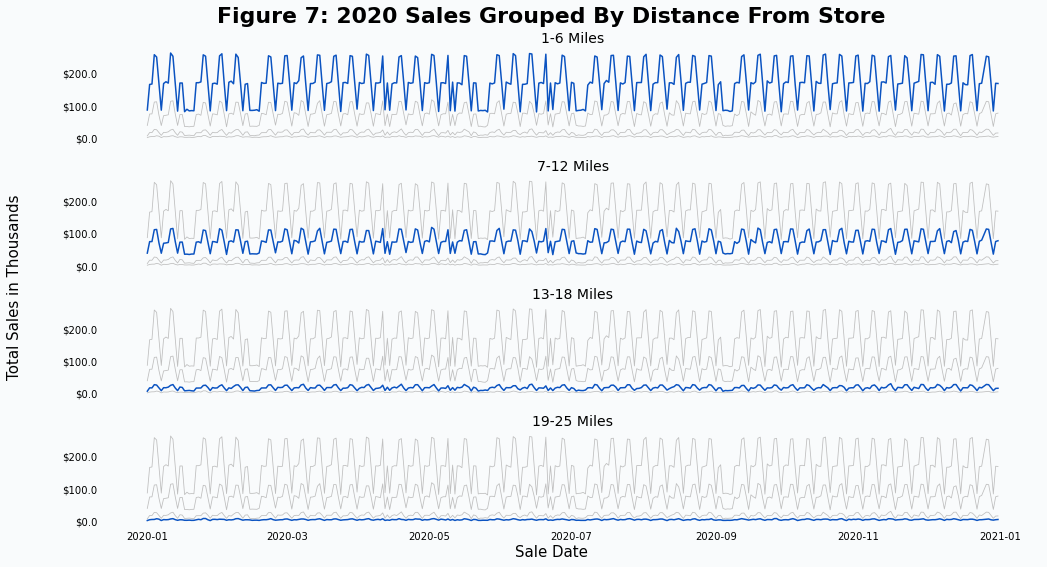

In [23]:
def plot_sales(density, data, ax):
    
    for bin_inner in bins:
    #Filter data to keep rows of the holiday.
        d = data[data["bins"] == bin_inner] 
        x = list(d["sale_date"].values)
        y = list(d["total_sales"].values.astype(float))

        if bin_inner == density:
            ax.plot(x, y, color="#0b53c1", lw=1.5, zorder=10)
        else:
            ax.plot(x, y, color="#BFBFBF", lw=.8)
        
    ax.yaxis.set_ticks_position('none') 
    ax.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
   
    ax.tick_params(bottom=False)
    ax.set_frame_on(False)

    ax.set_title(density, fontsize=14, fontweight=500)
    return ax


fig, axes = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(14, 7.5))
for idx, (ax, density) in enumerate(zip(axes.ravel(), bins)):
    plot_sales(density, df3_dense, ax)


#Making it pretty with annotations, labels, and layout. 
fig.subplots_adjust(wspace=0.1, left=0.025, right=0.975, bottom=0.11, top=0.82)
fig.tight_layout(pad = 1.5)
# Adds title.
fig.text(
    x=0.5, 
    y=1,
    s="Figure 7: 2020 Sales Grouped By Distance From Store",
    ha="center",
    va="center",
    ma="center",
    fontsize=22,
    fontweight="bold"
)

fig.text(0.5, 0, 'Sale Date', ha='center', fontsize = 15)
fig.text(-.04, .5, 'Total Sales in Thousands', va='center', rotation='vertical', fontsize = 15)
fig.set_facecolor("#f9fbfc")

# Executive Summary

To better acquire, retain, and market, we must define what our best customer's profile is. In Figures 1 through 7, we have provided data analysis to visualize the profiles of our customers. To define success, we need to first identify the strongest driver of total revenue. Based on Figure 1, we see that, for each customer, number of sales to that customer has a strong positive correlation with revenue extracted from that customer. Therefore, in each analysis, we define success as higher quantities of sales (more successful visits) or larger spend. For our model, we must identify customer characteristics which increase the chances of more frequent visits.   

In each figure, we analyze potential drivers for these success metrics. Specifically, we focus on distance from nearest store, zip code population density, and zip code population. Distance from nearest store has the strongest relationship with quantity of sales. This is likely driven by the time constraints, effort, and desirability of driving long distances for the product. We also identify relationships between zip code population and density, which may be due to network effects. For example, customers may be more likely to visit stores frequently if there are many other customers they know or see with products, or AGM packaging.

Based on our preliminary data analysis, we propose an explanatory OLS linear regression with quantity of sales as the observed variable and distance from store, zip code population, and density as explanatory variables. This model will provide us with the capability of estimating coefficients on these variables and an understanding of their practical and statistical significance. 

Based on the results of this model, we can target customers based on the demographics identified and offer loyalty programs, special discounts, and special rewards. 
